In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import pathlib

In [2]:
from matplotlib.colors import LogNorm

In [3]:
from NRSS.morphology import Morphology, Material, OpticalConstants

CyRSoXS
Size of Real               : 4
Maximum Number Of Material : 32
 __________________________________________________________________________________________________
|                                 Thanks for using Cy-RSoXS                                        |
|--------------------------------------------------------------------------------------------------|
|  Copyright          : Iowa State University                                                      |
|  License            : NIST                                                                       |
|  Acknowledgement    : ONR MURI                                                                   |
|                                                                                                  |
|  Developed at Iowa State University in collaboration with NIST                                   |
|                                                                                                  |
|  Please cite the fo

In [4]:
cwdPath = pathlib.Path().absolute() #this should pick the current working directory, which for Jupyter should be the directory in which the *.ipynb is in

In [5]:
energies = np.round(np.arange(275,300,1),1)

In [6]:
energies

array([275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287,
       288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299])

In [7]:
x = np.arange(0,512)
y = x.copy()
xx, yy = np.meshgrid(x,y)

In [8]:
x_center = xx.shape[0]//2
y_center = xx.shape[0]//2
radius = 10
shell = 5
core_idx = ((xx-x_center)**2 + (yy-y_center)**2 < radius**2)
shell_idx = ((xx-x_center)**2 + (yy-y_center)**2 >= radius**2) & ((xx-x_center)**2 + (yy-y_center)**2 < (radius+shell)**2)
phi_material1 = np.zeros(xx.shape)
phi_material1[core_idx] = 1
shell_material = np.zeros(xx.shape)
shell_material[shell_idx] = 1

combined = phi_material1 + shell_material

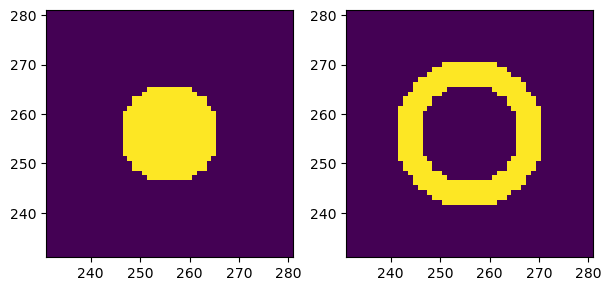

In [9]:
window = 25
fig, ax = plt.subplots(1,2,figsize=(6,3),constrained_layout=True)
ax[0].imshow(phi_material1)
ax[1].imshow(shell_material)
[{axes.set_xlim(x_center-window,x_center+window), axes.set_ylim(y_center-window,y_center+window)} for axes in ax]
plt.show()

In [10]:
from skimage.filters import sobel_v, sobel_h, sobel, gaussian

In [11]:
angles = np.arctan2(-sobel_h(combined),-sobel_v(combined))
angles_smoothed = np.arctan2(-sobel_h(gaussian(combined,sigma=5)),-sobel_v(gaussian(combined,sigma=5)))

In [12]:
# create Euler arrays
theta = np.zeros(xx.shape)
psi = theta.copy()

# Use Boolean indexing to only grab the orientation in the shell region
theta[shell_material.astype(bool)] = np.pi/2
psi[shell_material.astype(bool)] = angles_smoothed[shell_material.astype(bool)]


# I am bounding the psi orientation angles from 0 to pi for visualization, but Cy-RSoXS will accept any angle
psi = np.mod(psi,np.pi)

In [13]:
mat1_Vfrac = combined.copy() # volume fraction of all polyethylene (core and shell)
mat1_S = shell_material.copy() # alignment magnitude for polyethylene. Only the shell is aligned.

mat2_Vfrac = np.ones(xx.shape)
mat2_Vfrac -= mat1_Vfrac # everywhere there isn't polyethylene, we have vacuum

# we have no alignment for vacuum, and leave the euler angles as all zeros
mat2_S = np.zeros(xx.shape)
mat2_theta = mat2_S.copy()
mat2_psi = mat2_S.copy()

In [14]:
NumXY = xx.shape[0]
mat1_Vfrac = np.reshape(mat1_Vfrac,(1,NumXY,NumXY))
mat1_S = np.reshape(mat1_S,(1,NumXY,NumXY))
mat1_psi = np.reshape(psi,(1,NumXY,NumXY))
mat1_theta = np.reshape(theta,(1,NumXY,NumXY))

mat2_Vfrac = np.reshape(mat2_Vfrac,(1,NumXY,NumXY))
mat2_S = np.reshape(mat2_S,(1,NumXY,NumXY))
mat2_theta = np.reshape(mat2_theta,(1,NumXY,NumXY))
mat2_psi = np.reshape(mat2_psi,(1,NumXY,NumXY))

In [15]:
materialPath = cwdPath.parents[0] / 'coreshell_disk' #this goes back one directory from cwd and then goes forward into coreshell_disk

In [16]:
# load optical constants from previous Material1.txt file
mat1_consts = OpticalConstants.load_matfile(pathlib.Path(materialPath,'Material1.txt'),name='Material 1')

#create Material objects to hold the relevant voxel and optical constant information
mat1 = Material(materialID=1,Vfrac=mat1_Vfrac,S=mat1_S,
                psi=mat1_psi,theta=mat1_theta,energies=energies,
                opt_constants=mat1_consts.opt_constants,name='Material 1')

#automatically assigns zeros for optical constants if the name is vacuum
mat2 = Material(materialID=2,Vfrac=mat2_Vfrac,S=mat2_S,
                psi=mat2_psi,theta=mat2_theta,energies=energies,name='vacuum')

In [17]:
morph1 = Morphology(2,materials={1:mat1,2:mat2},PhysSize=5.0, create_cy_object=True)

In [18]:
morph1.inputData.print()

Required options:
NumMaterial          :  2
CaseType             :  Default
MorphologyType       :  EulerAngles
Dimensions [Z Y X]   :  [ 1 , 512 , 512 ]
PhysSize             :  5.0 nm
Energy               :  [275.0, 276.0, 277.0, 278.0, 279.0, 280.0, 281.0, 282.0, 283.0, 284.0, 285.0, 286.0, 287.0, 288.0, 289.0, 290.0, 291.0, 292.0, 293.0, 294.0, 295.0, 296.0, 297.0, 298.0, 299.0]
ERotation Angle      :  0.0  :  1.0  :  0.0
Morphology Order     :  ZYX
KVectorList           
                     :  [ 0.0 , 0.0 , 1.0 ]


Optional options:
Number of openMP threads :  4
Interpolation Type       :  Trilinear interpolation
Windowing Type           :  NONE
Rotation Mask            :  False
Reference Frame          :  LAB
Algorithm                :  CommunicationMinimizing


In [19]:
morph1.create_update_cy()

In [20]:
morph1.check_materials(quiet=False)

All material checks have passed


Dataset dimensions (Z, Y, X): 1 x 512 x 512
Number of Materials: 2

Material 1 Vfrac. Min: 0.0 Max: 1.0
Material 1 S. Min: 0.0 Max: 1.0
Material 1 theta. Min: 0.0 Max: 1.5707963267948966
Material 1 psi. Min: 0.0 Max: 3.141592653589793


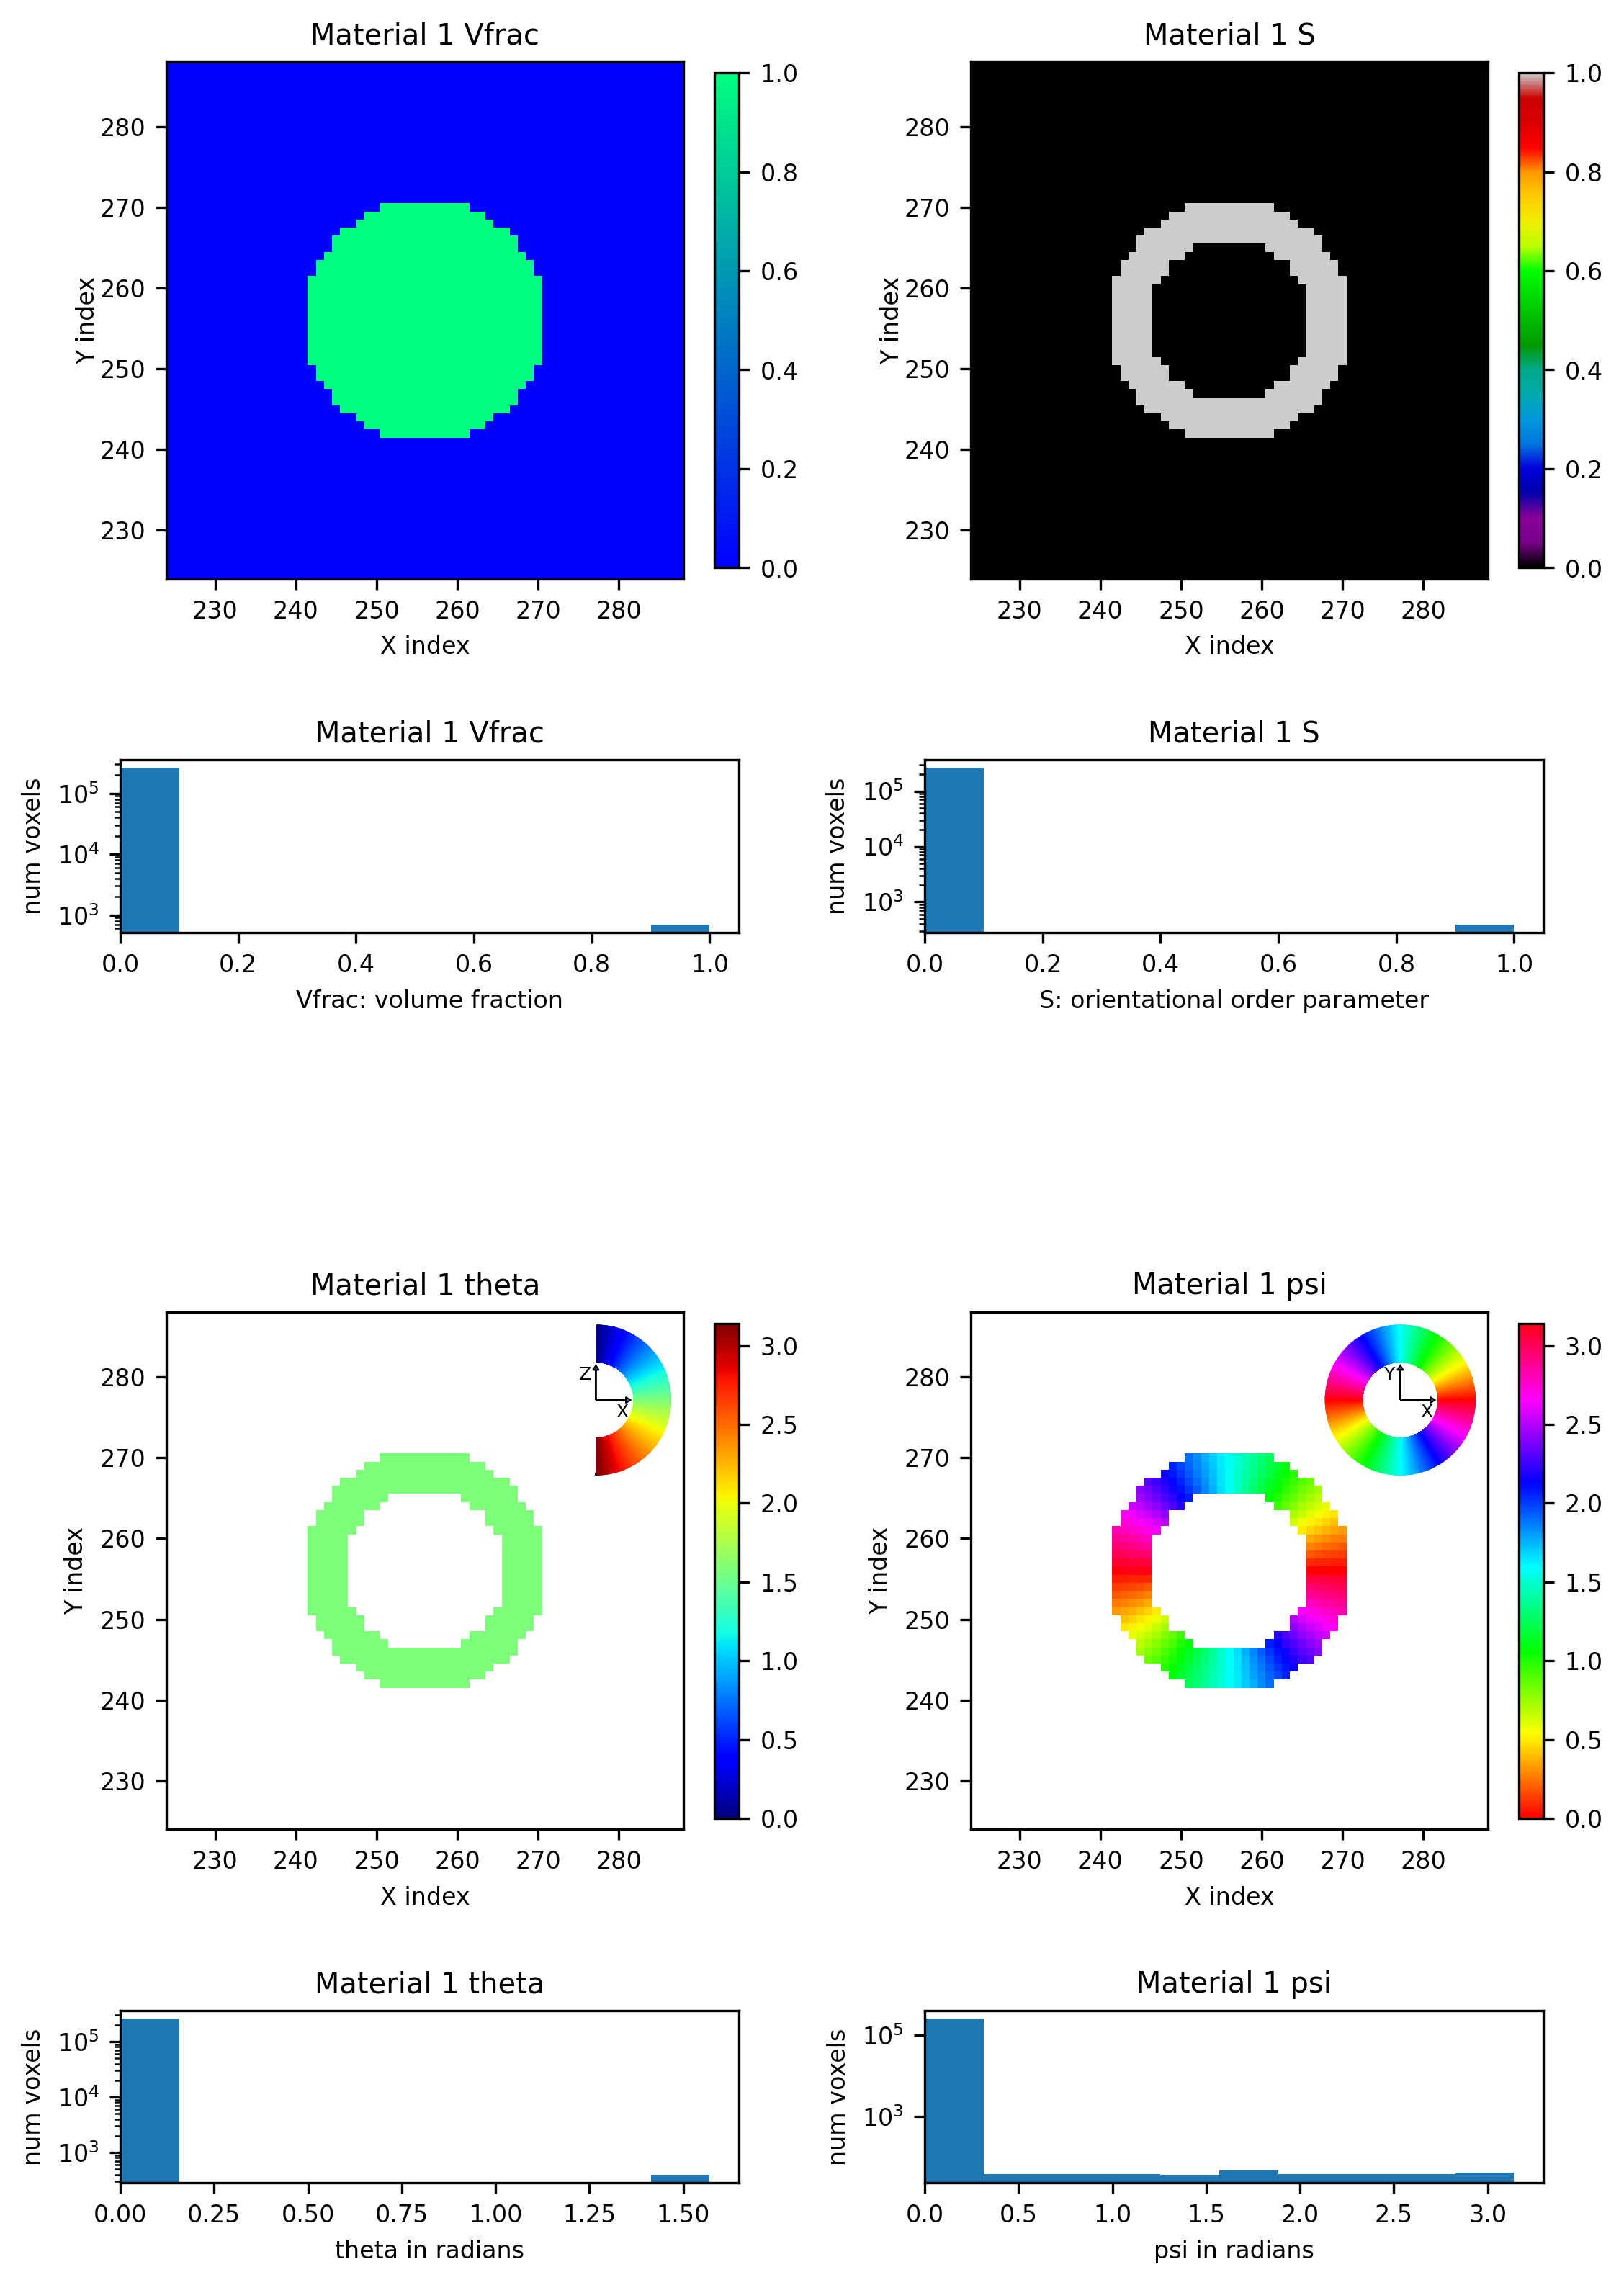

Material 2 Vfrac. Min: 0.0 Max: 1.0
Material 2 S. Min: 0.0 Max: 0.0
Material 2 theta. Min: 0.0 Max: 0.0
Material 2 psi. Min: 0.0 Max: 0.0


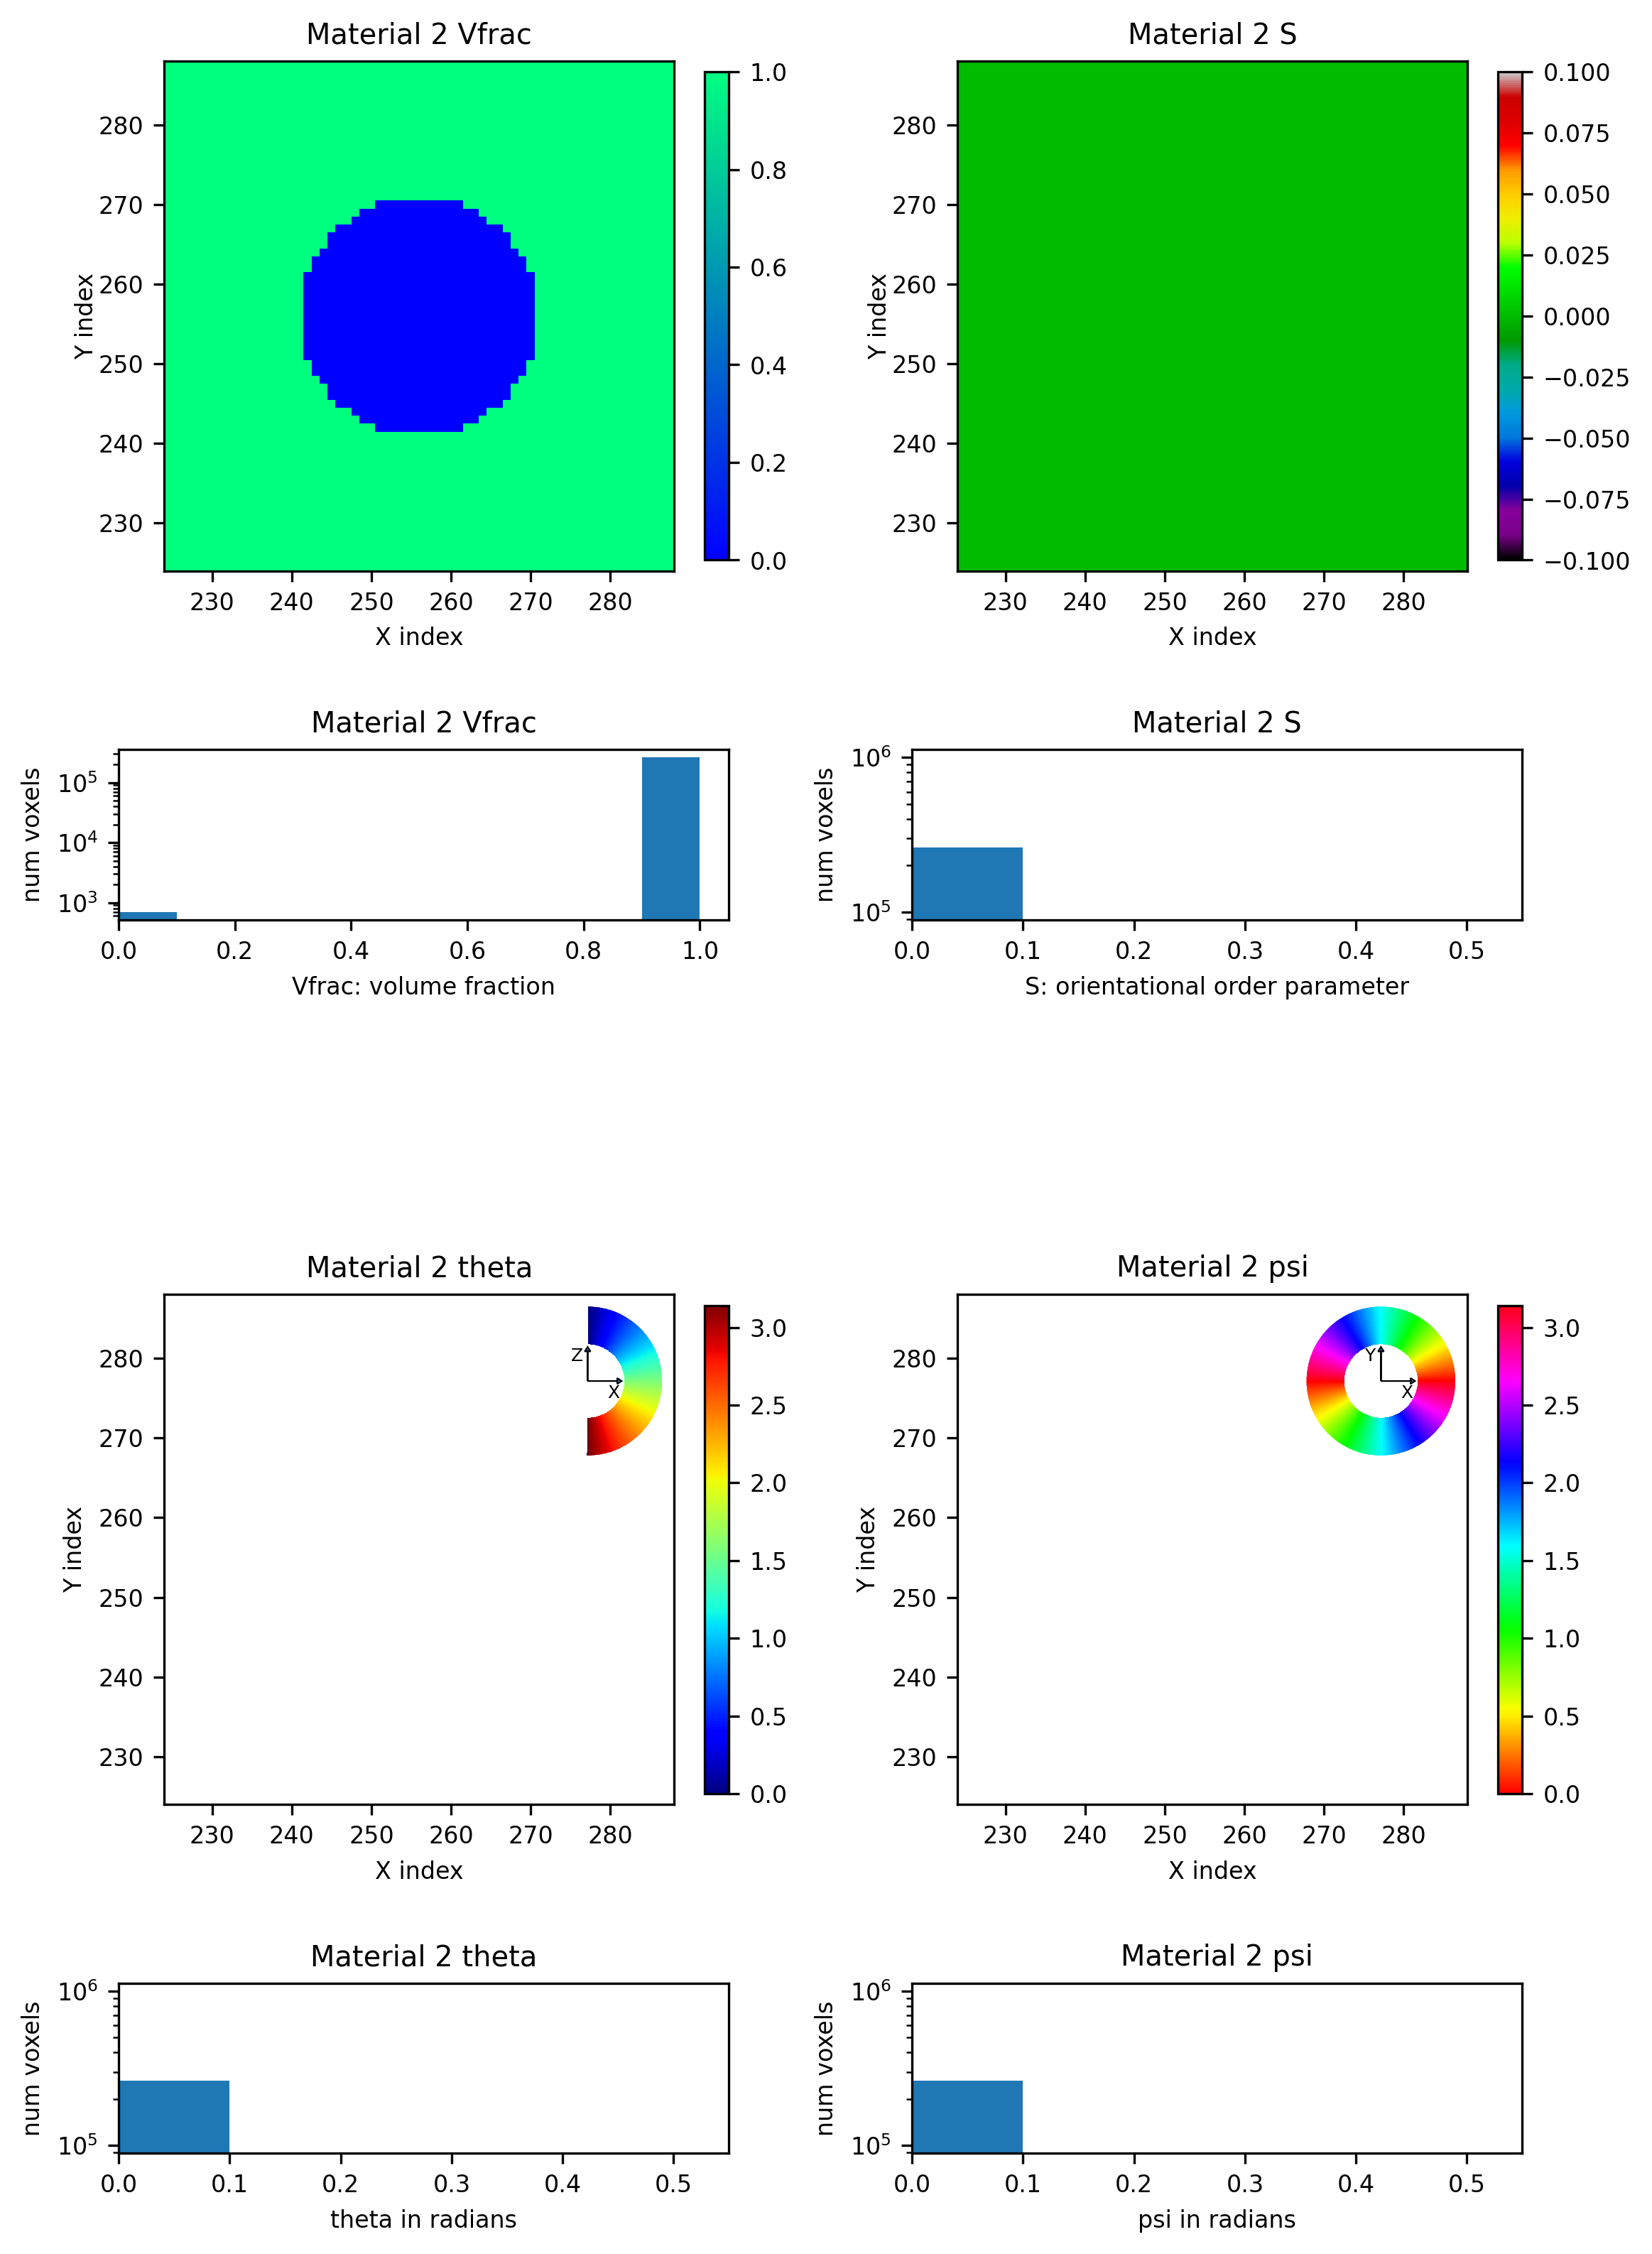

[]

<Figure size 640x480 with 0 Axes>

In [21]:
morph1.visualize_materials(subsample=64)

In [22]:
scattering_data = morph1.run()


 [STAT] Executing: 

Number of CUDA devices:3
[INFO] [GPU = Quadro RTX 8000] : 284eV -> 292eV
 [STAT] Energy = 284 starting 
 [STAT] Energy = 285 starting 
 [STAT] Energy = 286 starting 
 [STAT] Energy = 287 starting 
 [STAT] Energy = 288 starting 
 [STAT] Energy = 289 starting 
 [STAT] Energy = 290 starting 
 [STAT] Energy = 291 starting 
 [STAT] Energy = 292 starting 
[INFO] [GPU = Quadro RTX 8000] : 275eV -> 283eV
 [STAT] Energy = 275 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 283 starting 
[INFO] [GPU = Quadro RTX 8000] : 293eV -> 299eV
 [STAT] Energy = 293 starting 
 [STAT] Energy = 294 starting 
 [STAT] Energy = 295 starting 
 [STAT] Energy = 296 starting 
 [STAT] Energy = 297 starting 
 [STAT] Energy = 298 starting 
 [STAT] Energy = 299 starting 


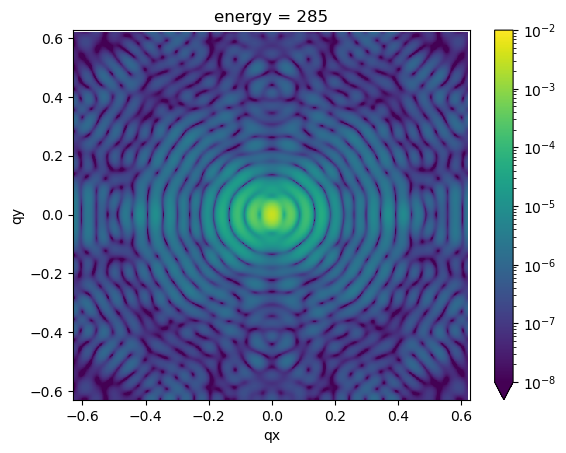

In [23]:
scattering_data.sel(energy=285.0).plot(norm=LogNorm(1e-8,1e-2))

In [24]:
morph1.EAngleRotation = [0.0, 1.0, 360.0]

In [25]:
scattering_data2 = morph1.run()


 [STAT] Executing: 

Number of CUDA devices:3
[INFO] [GPU = Quadro RTX 8000] : 275eV -> 283eV
[INFO] [GPU = Quadro RTX 8000] : 284eV -> 292eV
[INFO] [GPU = Quadro RTX 8000] : 293eV -> 299eV
 [STAT] Energy = 275 starting 
 [STAT] Energy = 284 starting 
 [STAT] Energy = 293 starting 
 [STAT] Energy = 276 starting 
 [STAT] Energy = 285 starting 
 [STAT] Energy = 294 starting 
 [STAT] Energy = 277 starting 
 [STAT] Energy = 286 starting 
 [STAT] Energy = 295 starting 
 [STAT] Energy = 296 starting 
 [STAT] Energy = 278 starting 
 [STAT] Energy = 287 starting 
 [STAT] Energy = 279 starting 
 [STAT] Energy = 297 starting 
 [STAT] Energy = 288 starting 
 [STAT] Energy = 280 starting 
 [STAT] Energy = 298 starting 
 [STAT] Energy = 289 starting 
 [STAT] Energy = 281 starting 
 [STAT] Energy = 299 starting 
 [STAT] Energy = 290 starting 
 [STAT] Energy = 282 starting 
 [STAT] Energy = 291 starting 
 [STAT] Energy = 283 starting 
 [STAT] Energy = 292 starting 


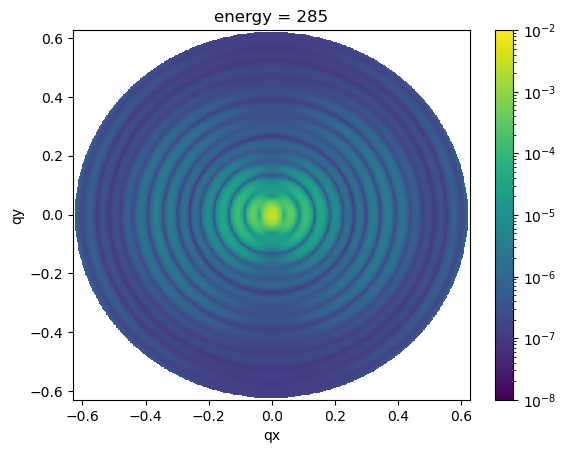

In [26]:
scattering_data2.sel(energy=285.0).plot(norm=LogNorm(1e-8,1e-2))
plt.show()

### Integrate using PyHyperScattering's Warp Polar Integrator

In [27]:
from PyHyperScattering.integrate import WPIntegrator
integrator = WPIntegrator()

Imports failed.  Are you running on a machine with proper libraries for databroker, tiled, etc.?


/home/deand/mambaforge/envs/deand/lib/python3.10/site-packages/PyHyperScattering/util.py:4: UserWarning: Could not import package for interactive integration utils.  Install holoviews and scikit-image.
  from PyHyperScattering import IntegrationUtils


In [28]:
data2_remeshed = integrator.integrateImageStack(scattering_data2)

  0%|          | 0/25 [00:00<?, ?it/s]

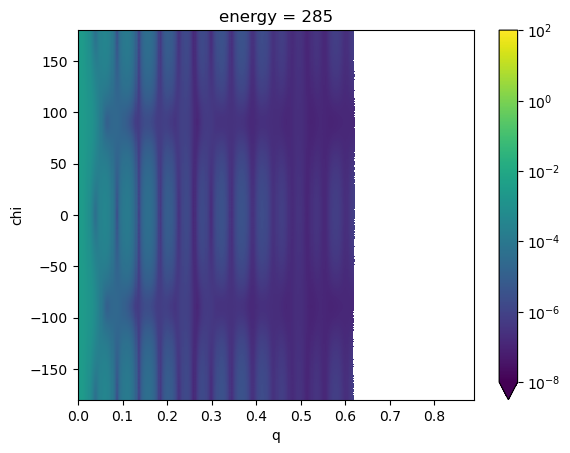

In [29]:
data2_remeshed.sel(energy=285).plot(norm=LogNorm(1e-8,1e2))

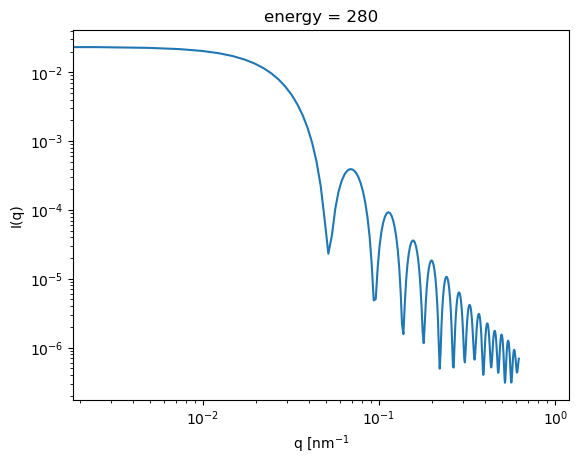

In [30]:
data2_remeshed.sel(energy=280).mean('chi').plot(yscale='log',xscale='log')
plt.xlabel('q [nm$^{-1}$')
plt.ylabel('I(q)')
plt.show()

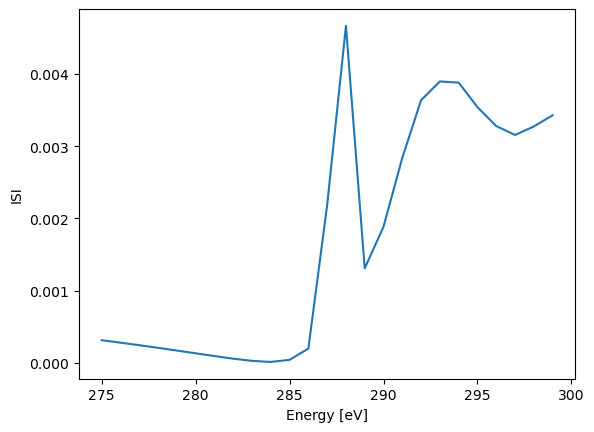

In [31]:
(data2_remeshed.mean('chi')*data2_remeshed.q**2).sel(q=slice(6e-3, 0.5)).sum('q').plot()
plt.ylabel('ISI')
plt.xlabel('Energy [eV]')
plt.show()

### By using the PyHyper integrator, we get access to the .rsoxs methods, allowing us to easily take slices in chi or generate A(q,E)

In [32]:
A = data2_remeshed.rsoxs.AR(chi_width=20)

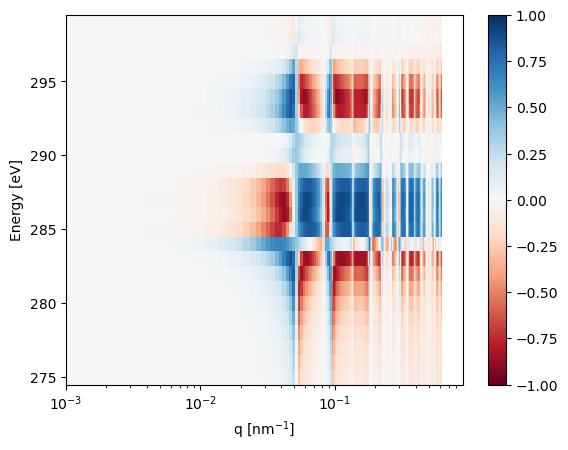

In [33]:
A.plot(cmap='RdBu', vmin=-1, vmax=1)
plt.xlabel('q [nm$^{-1}$]')
plt.ylabel('Energy [eV]')
plt.xscale('log')
plt.xlim(1e-3)
plt.show()

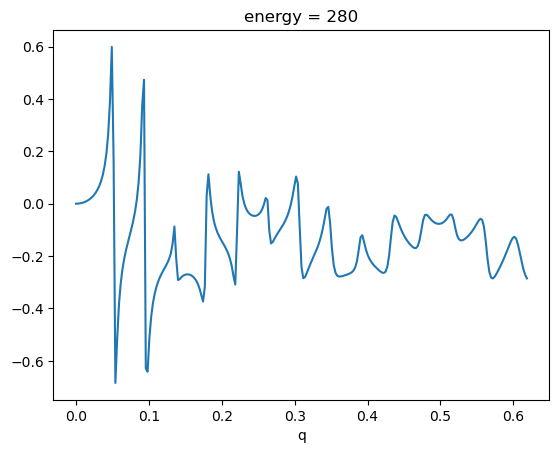

In [34]:
A.sel(energy=280).plot()